In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!pip install tensorflow

In [3]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

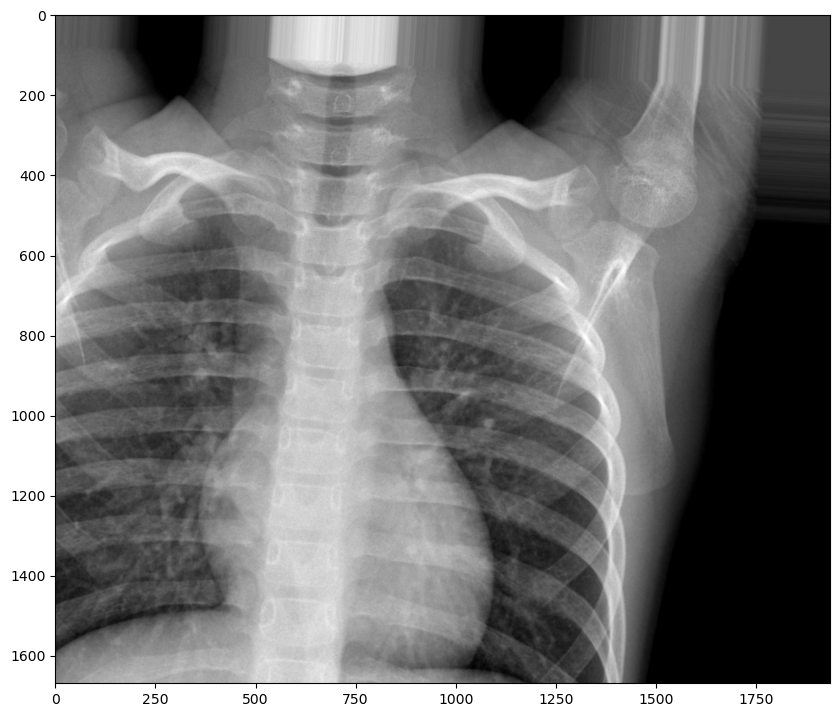

In [4]:
# simply show a picture
plt.figure(figsize= (10, 10))
img = mpimg.imread("Lung Disease Dataset/train/Normal/test_0_9774.jpeg")
plt.imshow(img)
plt.show()

In [5]:
# ImageDataGenerator (only can adjust on training data)
traingen = ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             zoom_range=0.2)
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [6]:
# flow_from_directory
train_it = traingen.flow_from_directory("Lung Disease Dataset/train", target_size = (224, 224))
val_it = traingen.flow_from_directory("Lung Disease Dataset/val", target_size = (224, 224))
test_it = traingen.flow_from_directory("Lung Disease Dataset/test", target_size = (224, 224))

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2018 images belonging to 5 classes.


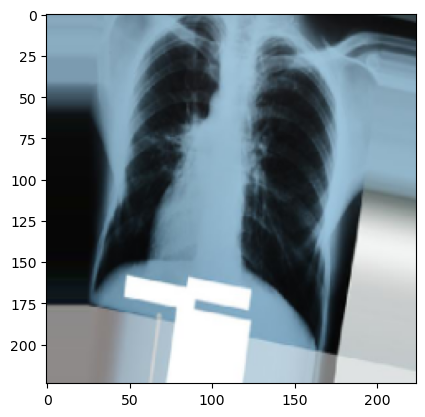

In [7]:
# show the picture after ImageDataGenerator
plt.figure()
plt.imshow(next(train_it)[0][0])
plt.show()

In [8]:
# use pre-train model of DenseNet201
base_model_201 = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model_201.layers:
  layer.trainable = False

x = layers.Flatten()(base_model_201.output)  # base_model_201.output
x = layers.Dropout(0.5)(x) # 
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(5, activation = 'softmax')(x)

model2 = tf.keras.models.Model(base_model_201.input, x)  # keras.models not keras.model


model2.compile('adam', loss = 'categorical_crossentropy',metrics = ['acc'])



### Earlystop
> This time I forget to use earlystop. Maybe I need to use it next time (because loss and acc don't change at finall)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor= "val_acc", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

model2.fit(train_it, validation_data= val_it, epochs=1, callbacks= [reduce_lr], steps_per_epoch=60, validation_steps=10)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - acc: 0.4976 - loss: 12.3294 - val_acc: 0.6969 - val_loss: 1.0848 - learning_rate: 0.0010


In [13]:
#model_dense = keras.models.load_model('densenet201.hdf5')
#model_dense.evaluate(test_it, steps= 1)

In [15]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model2)


tflite_model = converter.convert()


with open('densenet201.tflite', 'wb') as f:
    f.write(tflite_model)

print("Модель успешно конвертирована в формат .tflite и сохранена как 'densenet201.tflite'")


INFO:tensorflow:Assets written to: /var/folders/0c/c_6tn51n3t10xftzpctfty7h0000gn/T/tmpnnb8kg05/assets


INFO:tensorflow:Assets written to: /var/folders/0c/c_6tn51n3t10xftzpctfty7h0000gn/T/tmpnnb8kg05/assets


Saved artifact at '/var/folders/0c/c_6tn51n3t10xftzpctfty7h0000gn/T/tmpnnb8kg05'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  12961506384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023275792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023275024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023274448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023274256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023274640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12961503696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023275600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13023277328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1302327809

W0000 00:00:1736101530.255106 3662777 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1736101530.255823 3662777 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-01-05 23:25:30.256292: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/0c/c_6tn51n3t10xftzpctfty7h0000gn/T/tmpnnb8kg05
2025-01-05 23:25:30.276055: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-05 23:25:30.276081: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/0c/c_6tn51n3t10xftzpctfty7h0000gn/T/tmpnnb8kg05
2025-01-05 23:25:30.469408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-01-05 23:25:30.500539: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-05 23:25:31.771861: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at 

Модель успешно конвертирована в формат .tflite и сохранена как 'densenet201.tflite'


In [18]:
from IPython.display import display
from tensorflow.keras.preprocessing import image
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    

    classes = ['Bacterial_Pneumonia', 'Corona_Virus_Disease', 'Normal', 'Tuberculosis', 'Viral_Pneumonia']  
    print(f"Predicted Class: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    
    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

def on_file_upload(change):
   
    uploaded_file = change['new']
    if uploaded_file:
        file_path = list(uploaded_file.values())[0]['metadata']['name']
        print(f"File selected: {file_path}")
    
        predict_image(model_dense, file_path)

file_upload = f"BACTERIAL.jpeg"
display(file_upload)


'BACTERIAL.jpeg'

In [20]:
predict_image(model2 , file_upload)

FileNotFoundError: [Errno 2] No such file or directory: 'BACTERIAL.jpeg'

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


In [22]:
from IPython.display import display
from tensorflow.keras.preprocessing import image
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array /= 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    

    classes = ['Bacterial_Pneumonia', 'Corona_Virus_Disease', 'Normal', 'Tuberculosis', 'Viral_Pneumonia']  
    print(f"Predicted Class: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    
    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted_class]}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

def on_file_upload(change):
   
    uploaded_file = change['new']
    if uploaded_file:
        file_path = list(uploaded_file.values())[0]['metadata']['name']
        print(f"File selected: {file_path}")
    
        predict_image(model_dense, file_path)

file_upload = f"BACTERIA-7300836-0001.jpeg"
display(file_upload)


'BACTERIA-7300836-0001.jpeg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Bacterial_Pneumonia, Confidence: 0.94


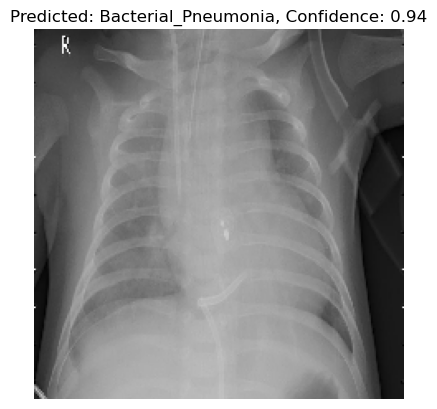

In [24]:
predict_image(model2 , file_upload)